## Importação de Bibliotecas

In [1]:

import torch
import numpy               as np
import pandas              as pd
import matplotlib.pyplot   as plt
import cv2                 as cv 
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import seaborn             as sns

from google.colab            import drive
from google.colab.patches    import cv2_imshow
from skimage                 import io
from PIL                     import Image
from torch                   import nn, optim
from torchvision             import datasets, transforms
from sklearn.model_selection import train_test_split


print("Versão:",torch.__version__)

Versão: 1.10.0+cu111


## Leitura da base de dados


In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Modelo de arquitetura CNN

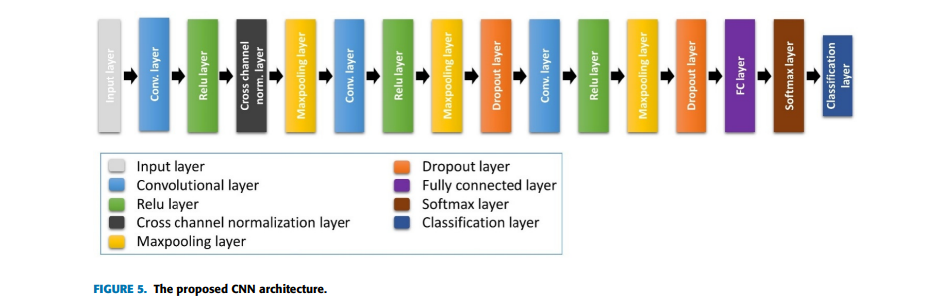

In [3]:
#Exemplo de arquitetura CNN
url = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/Images/multi-classification architecture CNN.png'
img = io.imread(url)
cv2_imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

No exemplo acima, podemos verificar que o modelo de CNN inicia-se (input) pelo número de subcamadas por canais de cores, isto é, rgb ou por escalas de cinza. Logo, nosso in_features da primera camada será 3 ou 1, respectivamente. De forma que, as arquiteturas de CNN mantém uma composição típica, definida por compor a convolução, a função de ativação, seguida por uma camada de pooling e assim em diente.

In [4]:
class classificador(nn.Module):
    def __init__ (self):
        super().__init__()
      
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=10, stride=(1,1), padding=(0,0))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=(1,1), padding=(2,2))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=(1,1), padding=(2,2))

        self.activation = nn.ReLU() 
        self.bnorm = nn.BatchNorm2d(num_features=64)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(in_features=16384, out_features=256)
        self.linear2 = nn.Linear(in_features=256, out_features=128)
        self.output = nn.Linear(in_features=128, out_features=4)

        self.dropout1 = nn.Dropout(p = 0.1)
        self.dropout2 = nn.Dropout(p = 0.2)
        
    def forward(self, X):
        X = self.pool(self.bnorm(self.activation(self.conv1(X))))
        X = self.dropout1(self.pool(self.activation(self.conv2(X))))
        X = self.dropout2(self.pool(self.activation(self.conv3(X))))
        X = self.flatten(X)
        
        X = self.activation(self.linear1(X))
        X = self.activation(self.linear2(X))
        X = self.output(X)
        
        return X

## Manipulação da Base de Dados

In [5]:
path_train = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/DadosClassificacaoTumor/Training'
path_test = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/DadosClassificacaoTumor/Testing'

In [6]:
transform_train = transforms.Compose(
    [
     transforms.Resize([128,128]),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomAffine(degrees=45, translate=(0, 0.07), shear=0.2, scale=(1,1.2)),
        transforms.ToTensor()
    ]
)

transform_test = transforms.Compose(
    [
     transforms.Resize([128,128]),
     transforms.ToTensor()
    ]
)

In [7]:
train_dataset = datasets.ImageFolder(path_train, transform=transform_train)
test_dataset = datasets.ImageFolder(path_test, transform=transform_test)

In [8]:
idx2class = {v: k for k, v in train_dataset.class_to_idx.items()}

def get_class_distribution(dataset_obj):
  count_dict = {k:0 for k, v in dataset_obj.class_to_idx.items()}
  for i in dataset_obj:
    y_labels = i[1]
    y_labels = idx2class[y_labels]
    count_dict[y_labels] += 1
  return count_dict

Text(0.5, 1.0, 'Distribuição de Imagens de ressonâncias magnéticas')

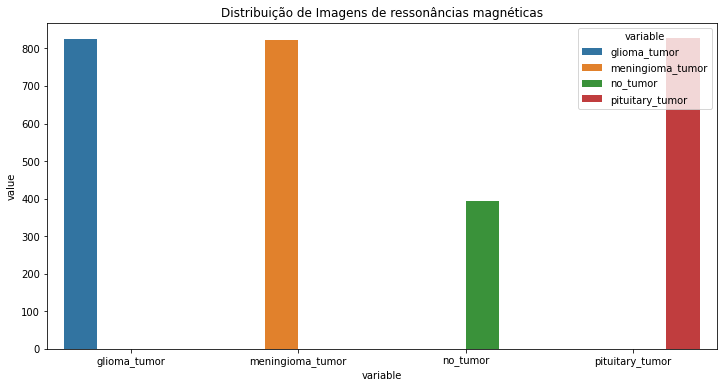

In [9]:
plt.figure(figsize=(12,6))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(train_dataset)])\
            .melt(), x = "variable", y="value", hue="variable")\
            .set_title('Distribuição de Imagens de ressonâncias magnéticas')

In [10]:
print(train_dataset, '\n', test_dataset)

Dataset ImageFolder
    Number of datapoints: 2870
    Root location: /content/gdrive/MyDrive/MRI_TUMOR_CNN/DadosClassificacaoTumor/Training
    StandardTransform
Transform: Compose(
               Resize(size=[128, 128], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           ) 
 Dataset ImageFolder
    Number of datapoints: 394
    Root location: /content/gdrive/MyDrive/MRI_TUMOR_CNN/DadosClassificacaoTumor/Testing
    StandardTransform
Transform: Compose(
               Resize(size=[128, 128], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [12]:
net = classificador()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [13]:
#Setamos a GPU necessária para realizar nossa classificação
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
print(device)

net.to(device)


cuda


classificador(
  (conv1): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (activation): ReLU()
  (bnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=16384, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=4, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

## Treinamento dos dados de Treino e Teste

In [14]:
loss_values = []
accu_values = []
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.
    for i, data in enumerate(loader):
        
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        #loss_values.append(running_loss / len(train_dataset))
        
        ps = F.softmax(outputs, dim=1)
        top_p, top_class = ps.topk(k=1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        
        accuracy= torch.mean(equals.type(torch.float))
        
        running_accuracy += accuracy
        
        #Imprimir os dados referentes a este loop
        print("Época {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}".format(epoch + 1, i+1, len(loader)\
                                                                                             , loss, accuracy), end= '\r')
    #Impressão referente à épocas
    print("Época {:3d} Finalizada: perda {:.5f} - precisão {:.5f}".format(epoch+1, running_loss/len(loader)\
                                                                         ,running_accuracy/len(loader)))
    loss_values.append(running_loss / len(loader))
    accu_values.append(running_accuracy/len(loader))

In [15]:
loss_train = [item for item in loss_values]
accu_train = [item for item in accu_values]

In [16]:
for epoch in range(50):
    print("Treinando...")
    training_loop(train_loader, epoch)
    net.eval()
    net.train()

Treinando...
Época   1 Finalizada: perda 1.11609 - precisão 0.54435
Treinando...
Época   2 Finalizada: perda 0.76335 - precisão 0.66787
Treinando...
Época   3 Finalizada: perda 0.65495 - precisão 0.71487
Treinando...
Época   4 Finalizada: perda 0.59541 - precisão 0.75786
Treinando...
Época   5 Finalizada: perda 0.52943 - precisão 0.77648
Treinando...
Época   6 Finalizada: perda 0.47863 - precisão 0.79416
Treinando...
Época   7 Finalizada: perda 0.43297 - precisão 0.82244
Treinando...
Época   8 Finalizada: perda 0.39975 - precisão 0.83949
Treinando...
Época   9 Finalizada: perda 0.34623 - precisão 0.85963
Treinando...
Época  10 Finalizada: perda 0.31432 - precisão 0.86982
Treinando...
Época  11 Finalizada: perda 0.27422 - precisão 0.88838
Treinando...
Época  12 Finalizada: perda 0.26898 - precisão 0.90164
Treinando...
Época  13 Finalizada: perda 0.22280 - precisão 0.91199
Treinando...
Época  14 Finalizada: perda 0.20541 - precisão 0.93024
Treinando...
Época  15 Finalizada: perda 0.19650

In [17]:
loss_train = [item for item in loss_values]
accu_train = [item for item in accu_values]
print(len(loss_train), len(accu_train))

20 20


In [18]:
accu_values.clear()
loss_values.clear()
for epoch in range(50):
    net.eval()
    print("Validando...")
    training_loop(test_loader, epoch)
    net.train()

Validando...
Época   1 Finalizada: perda 1.63057 - precisão 0.53365
Validando...
Época   2 Finalizada: perda 0.88510 - precisão 0.62308
Validando...
Época   3 Finalizada: perda 0.72390 - precisão 0.71442
Validando...
Época   4 Finalizada: perda 0.58393 - precisão 0.79038
Validando...
Época   5 Finalizada: perda 0.54906 - precisão 0.78990
Validando...
Época   6 Finalizada: perda 0.48992 - precisão 0.81875
Validando...
Época   7 Finalizada: perda 0.43855 - precisão 0.82644
Validando...
Época   8 Finalizada: perda 0.30205 - precisão 0.90625
Validando...
Época   9 Finalizada: perda 0.19739 - precisão 0.93029
Validando...
Época  10 Finalizada: perda 0.13364 - precisão 0.96394
Validando...
Época  11 Finalizada: perda 1.00900 - precisão 0.68894
Validando...
Época  12 Finalizada: perda 0.59779 - precisão 0.78029
Validando...
Época  13 Finalizada: perda 0.46555 - precisão 0.85096
Validando...
Época  14 Finalizada: perda 0.35279 - precisão 0.87933
Validando...
Época  15 Finalizada: perda 0.21089

In [19]:
loss_test = [item for item in loss_values]
accu_test = [item for item in accu_values]

In [20]:
print(len(loss_test), len(accu_test))

20 20


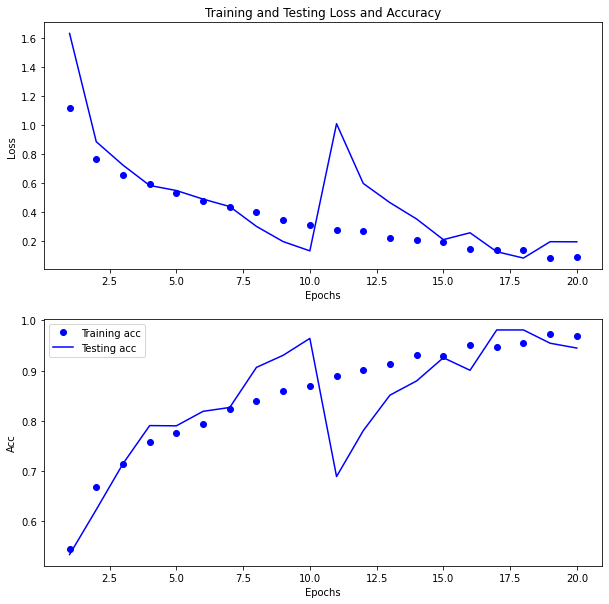

In [21]:
epochs_x = range(1, len(loss_test) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_train, 'bo', label='Training loss')
plt.plot(epochs_x, loss_test, 'b', label='Testing loss')
plt.title('Training and Testing Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
#val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, accu_train, 'bo', label='Training acc')
plt.plot(epochs_x, accu_test, 'b', label='Testing acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

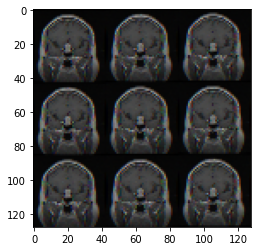

In [22]:
imagem1 = next(iter(train_loader))[0][1].view(128, 128, 3)
plt.imshow(imagem1)

In [23]:
imagem = imagem1.view(1, 3, 128, 128)
imagem = imagem.to(device)

In [24]:
previsao = net.forward(imagem)

previsao = F.softmax(previsao, dim=1)

previsao = previsao.cpu().detach().numpy()

In [25]:
print(previsao)

[[8.0611957e-03 1.2061853e-02 4.8710752e-04 9.7938997e-01]]


In [26]:
resultado = np.argmax(previsao)
print("Classe que a imagem pertence: {}".format(resultado))

Classe que a imagem pertence: 3


In [27]:
nb_classes = 4

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[ 95.,   2.,   1.,   2.],
        [  2., 112.,   0.,   1.],
        [  6.,   0.,  98.,   1.],
        [  0.,   0.,   0.,  74.]])


Text(0.5, 69.0, 'Test label')

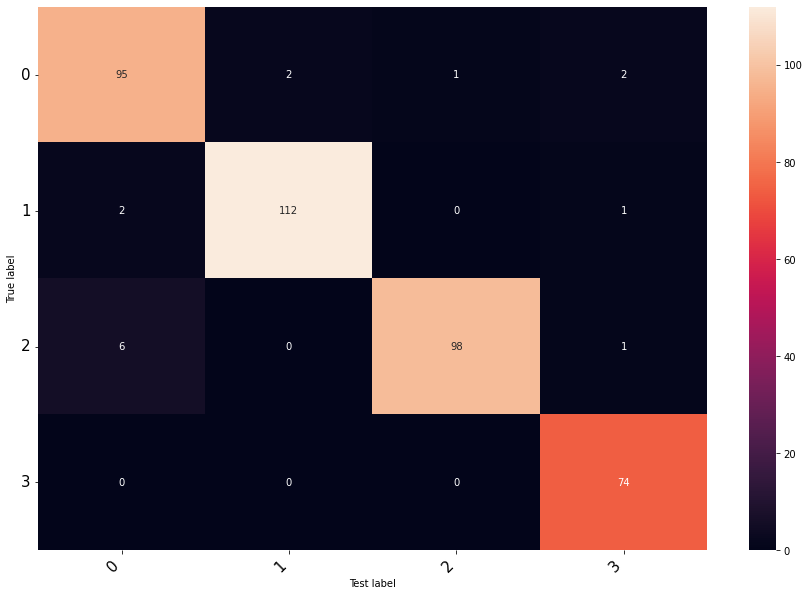

In [28]:
plt.figure(figsize=(15,10))
heatmap = sns.heatmap(pd.DataFrame(confusion_matrix).astype(int), annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=15)
plt.ylabel('True label')
plt.xlabel('Test label')

In [29]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([0.9500, 0.9739, 0.9333, 1.0000])
